In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from os import listdir
from os.path import isfile, join
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [2]:
all_stations=pd.read_csv('all_stations.csv')

In [3]:
useless_for_winter_method=[3,4,5,6,7,8,9,10,11]
useless_for_summer_method=[1,2,3,4,5,8,9,10,11,12]

In [65]:
class Metrics:
   
    def get_names(self):
        return ['mean_temp', 'mean_temp_trend', 'min_temp_trend', 'min_temp_num_trend', 
                'max_temp_trend', 'max_temp_num_trend', 'yearly_diff', 'yearly_diff_trend', 
                'winter_high_trend', 'winter_high_num_trend', 'fall_win_corr'
                #'autocorr2', 'autocorr4', 'autocorr6', 'autocorr8', 'autocorr10'
               ]
    
    def get_values(self):
        return [self.mean_temp, self.mean_temp_trend, self.min_temp_trend, self.min_temp_num_trend, 
                self.max_temp_trend, self.max_temp_num_trend, self.yearly_diff, self.yearly_diff_trend, self.winter_high_trend, 
                self.winter_high_num_trend, self.fall_win_corr
                #self.autocorr2, self.autocorr4, self.autocorr6, self.autocorr8, self.autocorr10
               ]

In [5]:
class BaseMethod:
    def __init__(self, useless_months=[]):
        self.useless_months = useless_months
    def remove_months(self, df):
        return df[~df['mo'].isin(self.useless_months)]
    def days_considered(self):
        return 30.4*(12-len(self.useless_months))   
    
class FindMin(BaseMethod):
    def clean_data(self, df):
        df=super().remove_months(df)
        return df[df['min'] < 200]
    def get_cutoff(self, df):
        return df['min'].quantile(0.01)
    def year_record(self, year_data):
        return year_data['min'].min()
    def count_yearly_extreme(self, year_data, cutoff):
        return year_data[year_data['min'] < cutoff]['min'].count()

class FindMax(BaseMethod):
    def clean_data(self, df):
        df=super().remove_months(df)
        return df[df['max'] < 200]
    def get_cutoff(self, df):
        return df['max'].quantile(0.99)
    def year_record(self, year_data):
        return year_data['max'].max()
    def count_yearly_extreme(self, year_data, cutoff):
        return year_data[year_data['max'] > cutoff]['max'].count()
    
class FindMean(BaseMethod):
    def clean_data(self, df):
        df=super().remove_months(df)
        return df[df['temp'] < 200]
    def get_cutoff(self, df):
        return 9999
    def year_record(self, year_data):
        return year_data.temp.mean()
    def count_yearly_extreme(self, year_data, cutoff):
        return 0    
    
class FindYearlyDiff(BaseMethod):
    def clean_data(self, df):
        df=super().remove_months(df)
        return df[(df['max'] < 200) & (df['min'] < 200)]
    def get_cutoff(self, df):
        return 9999
    def year_record(self, year_data):
        return year_data['max'].max() - year_data['min'].min()
    def count_yearly_extreme(self, year_data, cutoff):
        return 0    
    
class FindAutoCorr(BaseMethod):
    lag = 2
    def __init__(self, lag, useless_months = []):
        df=super().__init__(useless_months)
        self.lag = lag
    def clean_data(self, df):
        super().remove_months(df)
        return df[df['temp'] < 200].sort_values(['year', 'mo', 'da'])
    def get_cutoff(self, df):
        return 9999
    def year_record(self, year_data):
        return year_data['temp'].autocorr(self.lag)
    def count_yearly_extreme(self, year_data, cutoff):
        return 0    

In [7]:
def yearly_stat(df, find_method, make_plot=False):
    years_used = []
    yearly_record = []
    num_of_data = []
    df = find_method.clean_data(df)
    cutoff = find_method.get_cutoff(df)
    for year in range(1937,2021):
        year_data = df.loc[df.year == year]
        days_considered = find_method.days_considered()
        if ((len(year_data) > days_considered-10) and (len(year_data) < days_considered+10)):
            years_used.append(year)
            yearly_record.append(find_method.year_record(year_data))
            if cutoff != 9999:
                num_of_data.append(find_method.count_yearly_extreme(year_data, cutoff))
    num_trend=0
    if cutoff != 9999:
        df_num=pd.DataFrame({'year':years_used, 'num':num_of_data})
        df_num['rolling']=df_num['num'].rolling(10,min_periods=1).mean()
        reg_num = LinearRegression().fit(df_num['year'].values.reshape(-1,1), df_num['num'].values.reshape(-1,1))
        num_trend=reg_num.coef_[0][0]
    if make_plot:
        plt.figure(figsize=(15, 3))
        plt.subplot(131)
        plt.plot(years_used, yearly_record,'r.')
        if cutoff != 9999:
            plt.subplot(132)
            plt.plot(years_used, num_of_data,'r.')
            plt.subplot(133)
            plt.plot(df_num['year'], df_num['rolling'])
    reg_value = LinearRegression().fit(np.array(years_used).reshape(-1,1), np.array(yearly_record))
    return reg_value.coef_[0]*100, num_trend*100

In [56]:
def fall_winter_corr(df, make_plot=False):
    x=[]
    y=[]
    for year in range(1937,2021):
        fall_data = df.loc[(df.year == year) & (df.mo.isin([10,11]))]
        winter_data = df.loc[(df.year==year+1)&(df.mo.isin([1,2]))]
        if ((len(fall_data) > 50) and (len(fall_data) < 70) and (len(winter_data) > 50) and (len(winter_data)<70)):
            x.append(fall_data.temp.mean())
            winter_data=winter_data[winter_data['max']<200]
            y.append(winter_data['max'].mean())
    if make_plot:
        plt.figure(figsize=(15, 3))
        plt.subplot(131)
        plt.plot(x, y,'r.')
    df=pd.DataFrame({'fall':x, 'winter':y})
    return df.corr().iloc[0,1]

In [63]:
def find_mean_yearly_temp_diff(df):
    df = df[df['min']<200]
    df = df[df['max']<200]
    return (df['max']-df['min']).max()

(8.64668771606084, -8.643632158841044)
(10.547843435644568, 3.604359261633582)
(8.789564462471763, 0)
(1.9011557195837228, 0)
(-0.009925953935874976, 0)
-0.038949762122811905
54.199999999999996


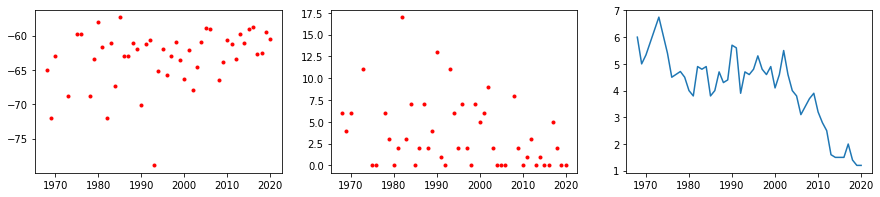

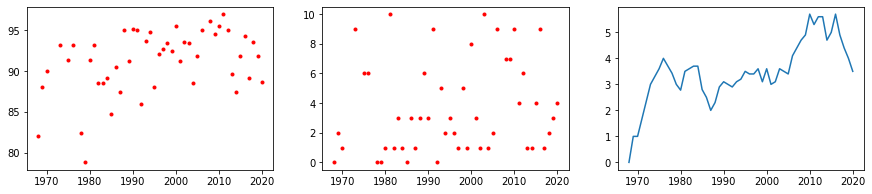

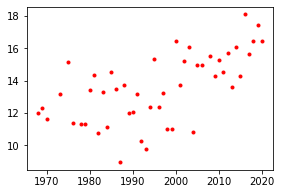

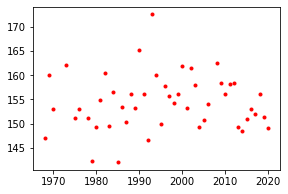

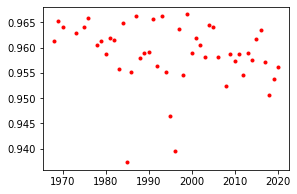

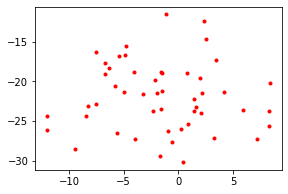

In [78]:
df = pd.read_csv(join('data_wholeyear/', '257030.csv'))
print(yearly_stat(df, FindMin(), True))
print(yearly_stat(df, FindMax(), True))
print(yearly_stat(df, FindMean(), True))
print(yearly_stat(df, FindYearlyDiff(), True))
print(yearly_stat(df, FindAutoCorr(2), True))
print(fall_winter_corr(df, True))
print(find_mean_yearly_temp_diff(df))

In [66]:
def find_stats(df):
    metrics = Metrics()
    metrics.mean_temp = df['temp'].mean()
    metrics.mean_temp_trend = yearly_stat(df, FindMean(), False)[0]
    metrics.min_temp_trend, metrics.min_temp_num_trend = yearly_stat(df, FindMin(), False)
    metrics.max_temp_trend, metrics.max_temp_num_trend = yearly_stat(df, FindMax(), False)
    metrics.yearly_diff = find_mean_yearly_temp_diff(df)
    metrics.yearly_diff_trend = yearly_stat(df, FindYearlyDiff(), False)[0]
    metrics.winter_high_trend, metrics.winter_high_num_trend = yearly_stat(df, FindMax(useless_for_winter_method), False)
    metrics.autocorr2 = yearly_stat(df, FindAutoCorr(2), False)[0]
    metrics.autocorr4 = yearly_stat(df, FindAutoCorr(4), False)[0]
    metrics.autocorr6 = yearly_stat(df, FindAutoCorr(6), False)[0]
    metrics.autocorr8 = yearly_stat(df, FindAutoCorr(8), False)[0]
    metrics.autocorr10 = yearly_stat(df, FindAutoCorr(10), False)[0]
    metrics.fall_win_corr = fall_winter_corr(df, False)
    return metrics

In [79]:
path = 'data_wholeyear/'
the_columns = ['stn', 'lon', 'lat', 'name']
the_columns.extend(Metrics().get_names())
df_master = pd.DataFrame({}, columns=the_columns)
for f in listdir(path):
    if 'csv' in f:
        station_id = f[0:6]
        if station_id in ['257030']:
            continue
        df = pd.read_csv(join(path, f))
        metrics = find_stats(df)
        if station_id not in all_stations['usaf'].values:
            print('no location info for station id', station_id)
            continue
        longitude = all_stations.loc[all_stations['usaf']==station_id, 'lon'].values[0]
        lattitude = all_stations.loc[all_stations['usaf']==station_id, 'lat'].values[0]
        name = all_stations.loc[all_stations['usaf']==station_id, 'name'].values[0]
        result_list = [station_id, longitude, lattitude, name]
        result_list.extend(metrics.get_values())
        df_master.loc[len(df_master)]=result_list


no location info for station id 723865


In [68]:
for col in df_master.columns[4:]:
    fig = px.scatter_mapbox(df_master, lat="lat", lon="lon", hover_name="stn",hover_data=the_columns[3:], color=col,
                            color_discrete_sequence=["fuchsia"], zoom=3, height=500)
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

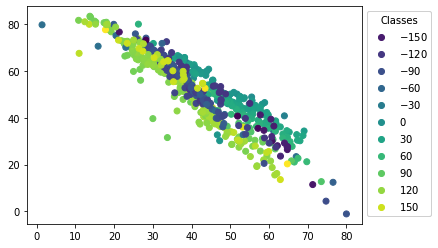

In [36]:
fig, ax = plt.subplots()
scatter = ax.scatter(df_master['lat'].abs(), df_master['mean_temp'], c=df_master['lon'])
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes",bbox_to_anchor=(1, 1))
ax.add_artist(legend1)

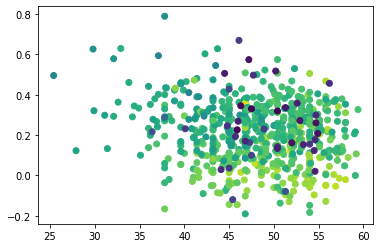

In [71]:
fig, ax = plt.subplots()
scatter = ax.scatter(df_master['yearly_diff'], df_master['fall_win_corr'], c=df_master['lat'])

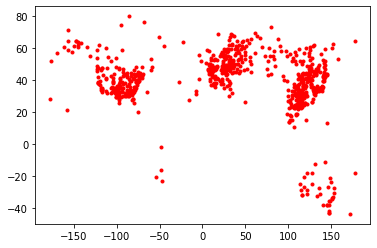

In [42]:
plt.plot(df_master['lon'], df_master['lat'],'r.')

0.26932417598347136

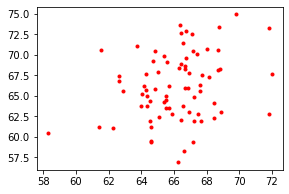

In [55]:
df = pd.read_csv(join('data_wholeyear/', '722535.csv'))
indication(df, True)